In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

In [8]:
def confusao(truth, pred):
    retorno = {'tp':0,'fp':0, 'tn':0, 'fn':0}
    for x in range(len(pred)):
        if pred[x] == 1 and truth[x] == 1:
            retorno['tp'] += 1
        elif pred[x] == 1 and truth[x] == 0:
            retorno['fp'] += 1
        elif pred[x] == 0 and truth[x] == 1:
            retorno['fn'] += 1
        else:
            retorno['tn'] += 1
    
    retorno['precisao'] = retorno['tp'] / (retorno['tp'] + retorno['fp']) if (retorno['tp'] + retorno['fp']) > 0 else None
    retorno['recall'] = retorno['tp'] / (retorno['tp'] + retorno['fn']) if (retorno['tp'] + retorno['fn']) > 0 else None
    if retorno['precisao'] is None or retorno['recall'] is not None:
        retorno['f1'] = None
    elif retorno['precisao'] + retorno['recall'] == 0:
        retorno['f1'] = None
    else:
        retorno['f1'] = 2 * (retorno['precisao'] * retorno['recall']) / (retorno['precisao'] + retorno['recall'])

    retorno['precisao_relativa'] = retorno['tp'] / sum(truth)
    
    return retorno

In [9]:
objetos = ['medicine','chocolate_milk', 'heineken', 'yellow_juice',
           'red_juice', 'purple_juice', 'milk_bottle', 'milk_box',
           'cereal', 'iron_man', 'shampoo', 'monster', 'tea_box']
gabarito = pd.read_csv('gabarito_objetos.csv', index_col='imagem')
resultados = pd.read_csv('logfile.csv')

In [10]:
gabarito.sum()

medicine          52
chocolate_milk    51
heineken          40
yellow_juice      47
red_juice         41
purple_juice      42
milk_bottle       58
milk_box          53
cereal            49
iron_man          44
shampoo           47
monster           53
tea_box           59
dtype: int64

In [11]:
matriz_confusao = pd.DataFrame(columns=['tp','fp','tn','fn','precisao_relativa'])

for index, row in tqdm(resultados.iterrows(), total=resultados.shape[0]):
    imagem = row['image']
    verdade = list(gabarito.loc[imagem, :])
    predicao = list(row[objetos])
    vetor_confusao = confusao(verdade, predicao)
    
    for valor in vetor_confusao:
        matriz_confusao.loc[index, valor] = vetor_confusao[valor]

resultados = pd.concat([resultados, matriz_confusao], axis=1)
resultados[objetos + ['tp','fp','tn','fn']] = resultados[objetos + ['tp','fp','tn','fn']].astype('int')
resultados[['precisao_relativa', 'confidence', 'precisao', 'recall', 'f1']] = resultados[['precisao_relativa', 'confidence', 'precisao', 'recall', 'f1']].astype('float')
resultados[resultados['detector'] != 'ssd'][['pontos','base']] = resultados[resultados['detector'] != 'ssd'][['pontos','base']].astype('int')

resultados['confidence'] = round(resultados['confidence'],1)


100%|██████████| 7000/7000 [00:35<00:00, 197.04it/s]
/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [12]:
resultados_sift = resultados[resultados['detector'] != 'ssd']

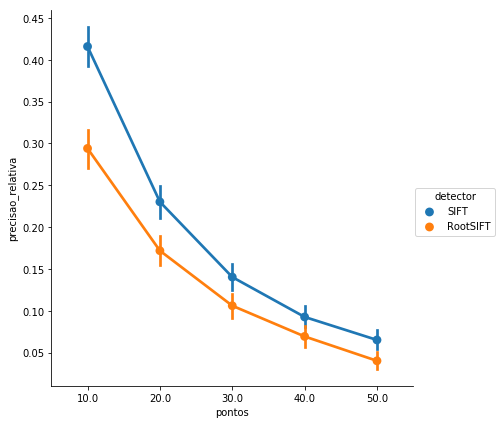

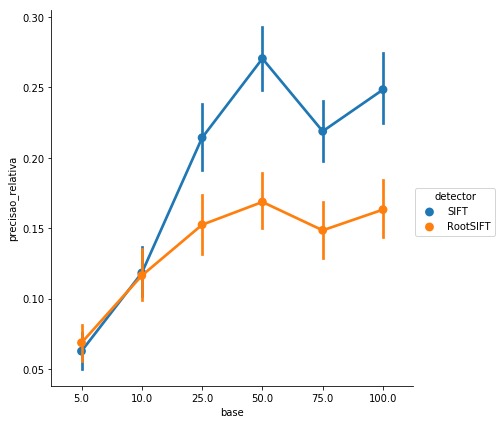

In [13]:
for valor_de_interesse in ['pontos', 'base']:
    g = sns.factorplot(x=valor_de_interesse, y='precisao_relativa', hue='detector', data=resultados_sift,
                       size=6)
    plt.savefig('precisao_relativa_x_'+valor_de_interesse + '.pdf')

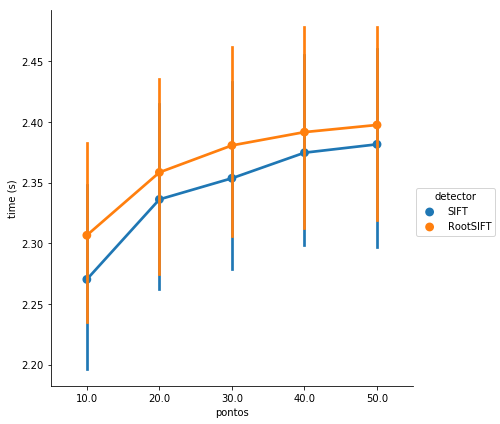

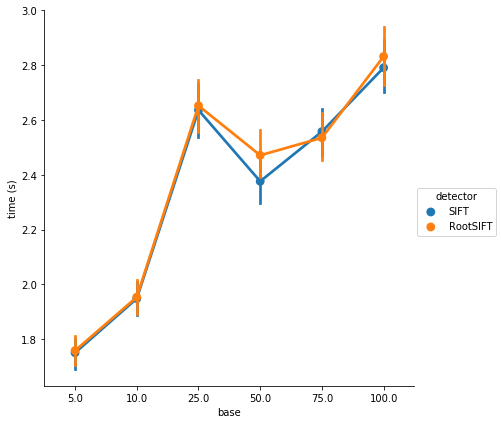

In [14]:
for valor_de_interesse in ['pontos', 'base']:
    g = sns.factorplot(x=valor_de_interesse, y='time (s)', hue='detector', data=resultados_sift,
                       size=6)
    plt.savefig('framerate_x_'+valor_de_interesse + '.pdf')

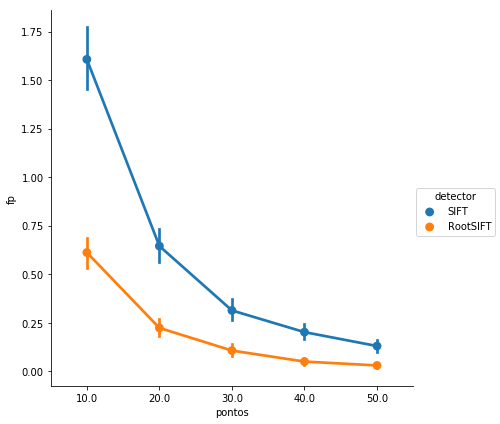

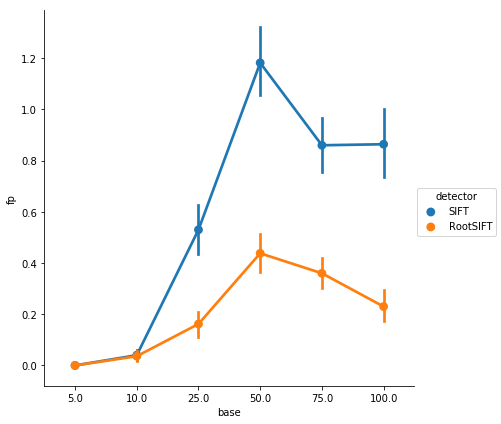

In [15]:
for valor_de_interesse in ['pontos', 'base']:
    g = sns.factorplot(x=valor_de_interesse, y='fp', hue='detector', data=resultados_sift,
                       size=6)
    plt.savefig('fp_x_'+valor_de_interesse + '.pdf')

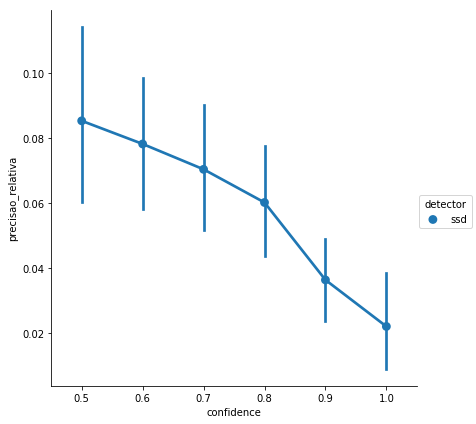

In [16]:
resultados_ssd = resultados[resultados['detector'] == 'ssd']

sns.factorplot(x='confidence', y='precisao_relativa', hue='detector', data=resultados_ssd, size=6)
plt.savefig('precisao_relativa_x_confidence.pdf')

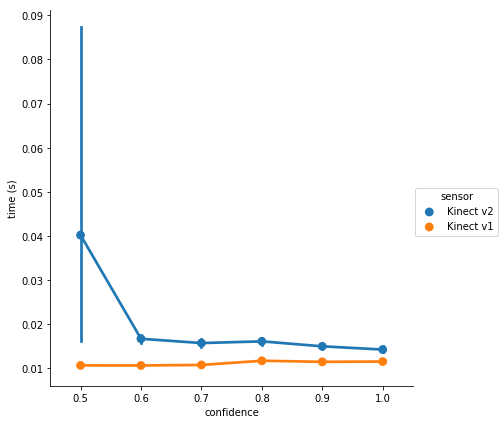

In [17]:
sns.factorplot(x='confidence', y='time (s)', hue='sensor', data=resultados_ssd, size=6)

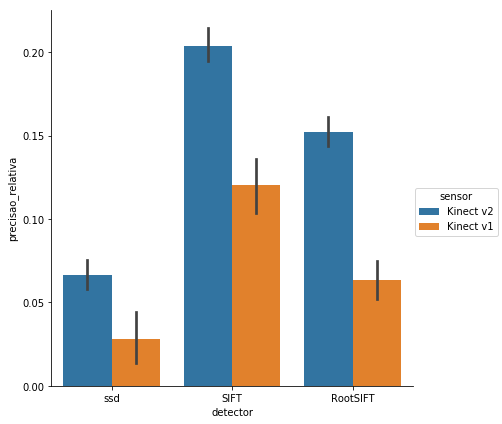

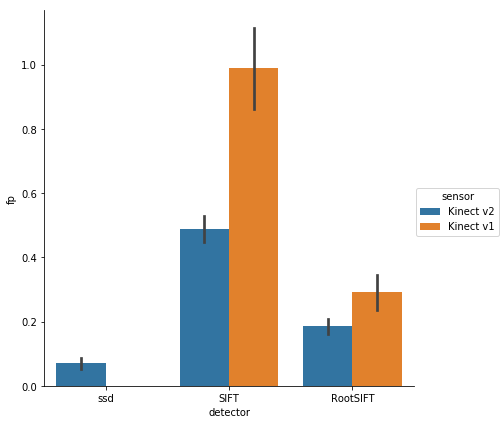

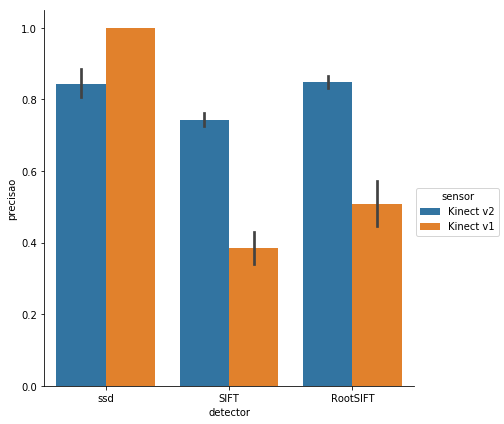

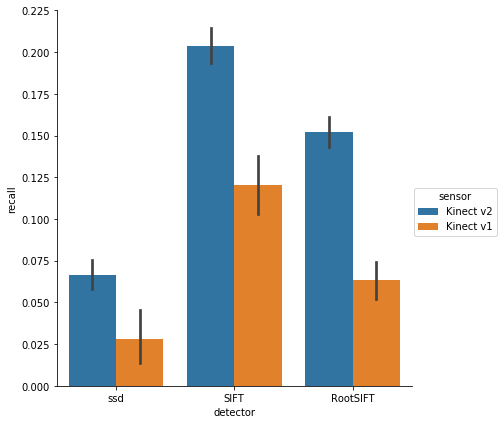

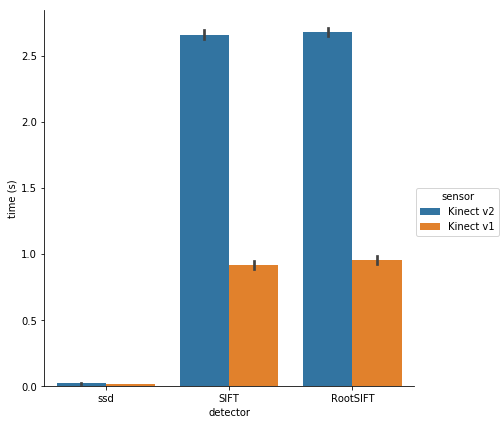

In [18]:
sns.factorplot(y='precisao_relativa', x='detector', hue='sensor', data=resultados, size=6,kind='bar')
plt.savefig('precisao_relativa_x_detector.pdf')
sns.factorplot(y='fp', x='detector', hue='sensor', data=resultados, size=6,kind='bar')
plt.savefig('fp_x_detector.pdf')
sns.factorplot(y='precisao', x='detector', hue='sensor', data=resultados, size=6,kind='bar')
plt.savefig('precisao_x_detector.pdf')
sns.factorplot(y='recall', x='detector', hue='sensor', data=resultados, size=6,kind='bar')
plt.savefig('recall_x_detector.pdf')
sns.factorplot(y='time (s)', x='detector', hue='sensor', data=resultados, size=6,kind='bar')
plt.savefig('time_x_detector.pdf')

In [19]:
x = [a for a in range(10,51,10)]
y = [5,10,25,50,75,100]
z = ['RootSIFT', 'SIFT']

results_list = []
for detector in list(itertools.combinations_with_replacement(z,2)):
    for value in list(itertools.combinations_with_replacement(x,2)):
        for item in list(itertools.combinations_with_replacement(y,2)):
            a = resultados[(resultados['detector']==detector[0]) & (resultados['pontos']==value[0]) & (resultados['base']==item[0])]['precisao_relativa']
            b = resultados[(resultados['detector']==detector[1]) & (resultados['pontos']==value[1]) & (resultados['base']==item[1])]['precisao_relativa']
            string_a = detector[0]+'_'+str(value[0])+'_'+str(item[0])
            string_b = detector[1]+'_'+str(value[1])+'_'+str(item[1])
            equal=True if item[0]==item[1] and value[0]==value[1] and detector[0]==detector[1] else results_list.append((string_a,string_b,stats.ttest_rel(a,b)))# print(stats.ttest_rel(a,b),detector,value,item)

for detector in z:
    for value in x:
        for item in y:
            a = resultados[(resultados['detector']==detector) & (resultados['pontos']==value) & (resultados['base']==item)]['precisao_relativa']
            c = resultados[(resultados['detector']=='ssd')]['precisao_relativa']
            string_a = detector+'_'+str(value)+'_'+str(item)
            results_list.append((string_a,'ssd',stats.ttest_rel(a,c)))

# [print(results_list[x]) for x in range(len(results_list))]

ValueError: unequal length arrays

In [ ]:
csv_list = [('method_points_%folder', 'method_points_%folder 2', 'statistic', 'pvalue')]

for item in results_list:
    csv_list.append((item[0], item[1], item[2].statistic, item[2].pvalue))

df = pd.DataFrame(csv_list)
df.to_csv('T_test.csv', encoding='utf-8', index=False)